# Carseats data example

For our first example, we consider a dataset from the ISLP text, the Carseats data.  One of the variables in the dataset is Sales, and we will convert it to a categorical response "Yes" if Sales>8 and "No" otherwise. We will then train a classification tree to predict if Sales>8 or not using the other features. With minor changes, this example is similar to Section 8.3 in ISLP.

You can read more about the data here https://islp.readthedocs.io/en/latest/datasets/Carseats.html

First, we import some packages and functions.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss, confusion_matrix)

The first line below reads in the Carseats data to a pandas data frame.  Then we use one hot encoding to represent the categorical variables - the categorical variables here are ShelveLoc (three levels), Urban (two levels) and US (two levels).  Then we drop the original categorical variables, then replace them with the matrix of binary dummmy variables.  Finally, we create a new categorical response variable High ("Yes" for Sales>8, "No" otherwise) and take a look at the new feature matrix.

In [7]:
Carseats = pd.read_csv('Carseats.csv',
                      index_col=0)

one_hot_data = pd.get_dummies(Carseats[['ShelveLoc','Urban','US']])
Carseats.drop(columns=['ShelveLoc','Urban','US'],inplace=True)
Carseats = Carseats.join(one_hot_data)
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")

Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,9.50,138,73,11,276,120,42,17,True,False,False,False,True,False,True
1,11.22,111,48,16,260,83,65,10,False,True,False,False,True,False,True
2,10.06,113,35,10,269,80,59,12,False,False,True,False,True,False,True
3,7.40,117,100,4,466,97,55,14,False,False,True,False,True,False,True
4,4.15,141,64,3,340,128,38,13,True,False,False,False,True,True,False


Next we extract a list of feature names, and collect the features into a data frame X

In [8]:
feature_names=list(Carseats.columns[1:])
X=Carseats[feature_names]
X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,138,73,11,276,120,42,17,True,False,False,False,True,False,True
1,111,48,16,260,83,65,10,False,True,False,False,True,False,True
2,113,35,10,269,80,59,12,False,False,True,False,True,False,True
3,117,100,4,466,97,55,14,False,False,True,False,True,False,True
4,141,64,3,340,128,38,13,True,False,False,False,True,True,False


Now we initialize our decision tree classifier object.  The argument criterion determines the criterion for splitting and pruning (we choose entropy) and max_depth allows us to set the maximum tree depth.  There are many other options, look at the help to see all options and their defaults).  clf is an "estimator" object in scikit-learn and we fit the tree with response High and feature matrix X.

In [12]:
clf = DTC(criterion = "entropy",
          max_depth = 3, random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

What accuracy does our classifier attain on the training data?

In [13]:
accuracy_score(High, clf.predict(X))

0.79

Another measure of fit to the training data is twice the negative log-likelihood

In [14]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.47106470626493574

Now we plot our classification tree

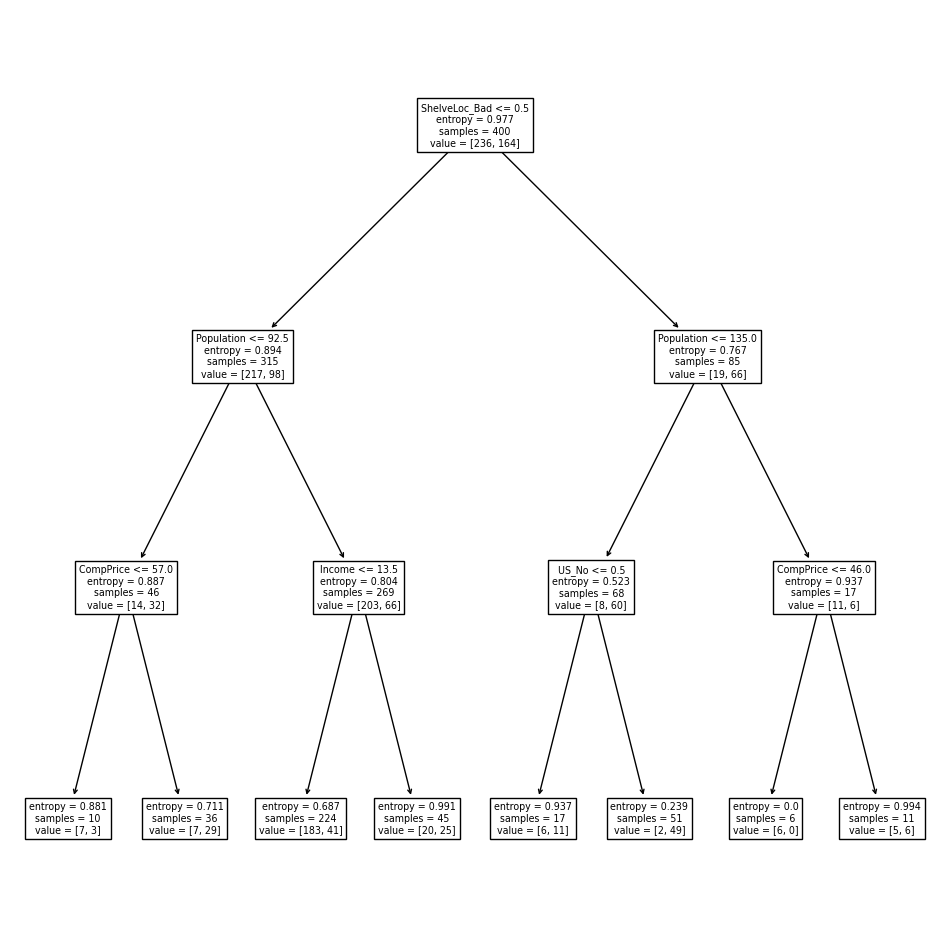

In [64]:
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [16]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc_Good <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc_Good >  0.50
|   |--- Price <= 135.00
|   |   |--- US_No <= 0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |   |--- US_No >  0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



Let's split the data randomly, with a test set of size 200, fit to the training set and look at the classification accuracy on the test set.  We get 69% accuracy, which is unsurprisingly lower than what we achieved on the training set.

In [18]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             X,
                             High,
                             cv=validation)
results['test_score']

array([0.69])

Next, let's try pruning to see if we can improve performance.  We split the data into training and test, with 30% test data.  

In [20]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                High,
                                test_size=0.3,
                                random_state=0)

Fit the tree to the trainning data, and see how well we predict for the test set.  So far there is no pruning.  This time we don't restrict the tree depth to a maximum of 3.

In [21]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.6666666666666666

Next we will select the best value of $\alpha$ for cost-complexity pruning based on 5-fold cross-validation within the training data.

In [27]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.7892857142857143

Let's plot the best tree after pruning

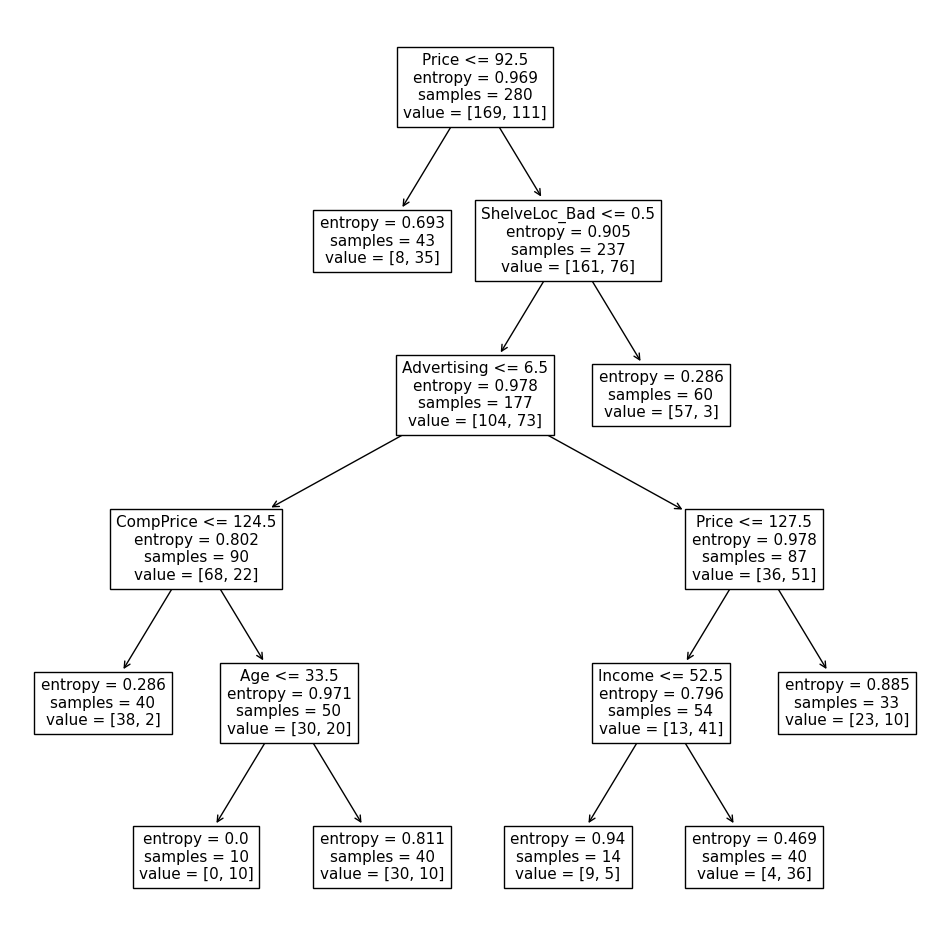

In [28]:
ax = plt.subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

Next let's look at the number of terminal nodes in the best tree

In [25]:
best_.tree_.n_leaves

8

Next let's look at the accuracy on the test set, and the confusion matrix.  Why do you think we need to estimate the accuracy on a separate test set, when we have an estimate of accuracy from the training set obtained by cross-validation?

In [30]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_matrix(best_.predict(X_test),
                            High_test)
confusion

0.625


array([[54, 32],
       [13, 21]])